### ファインチューニングチュートリアルのコード
[教材はここ](https://github.com/pytorch/tutorials/blob/d686b662932a380a58b7683425faa00c06bcf502/intermediate_source/torchvision_tutorial.rst)
- 流れ  
COCOで事前学習されたMask R-CNNモデルを用いて、歩行者検出のデータセットでファインチューニングする。

In [1]:
import os
import numpy as np
import torch
from PIL import Image
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
# from torchvision import transforms as T
# from engine import train_one_epoch, evaluate
# import utils

In [19]:
class PennFudanDataset(torch.utils.data.Dataset):
    """
    Penn-Fudan Database for Pedestrian Detection and Segmentation用のカスタムデータセットクラス
    - 画像とマスク画像の読み込み
    - マスクから物体の境界ボックスを自動計算
    - 物体検出・セグメンテーション用のアノテーション情報の生成
    """
    
    def __init__(self, root, transforms):
        """
        データセットの初期化
        
        Args:
            root (str): データセットのルートディレクトリパス
                       root = /share/dtu_drone_tutorial/PennFudanPedの想定
            transforms (callable, optional): 画像とターゲットに適用する変換処理(前処理)
        """
        self.root = root
        self.transforms = transforms

        # ソートすることで、imageとmaskが順番に対応するようになる
        # PNGImagesディレクトリから画像ファイル名のリストを取得（ソート済み）
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        # PedMasksディレクトリからマスク画像ファイル名のリストを取得（ソート済み）
        self.mask = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        """
        指定されたインデックスのデータアイテムを取得
        
        Args:
            idx (int): データのインデックス
            
        Returns:
            tuple: (image, target) のタプル
                - image: PIL画像またはTensorに変換された画像
                - target: 物体検出用のアノテーション辞書
        """
        # 指定されたインデックスの画像とマスクのファイルパスを構築
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.mask[idx])

        # 元画像をRGBモードで読み込み（物体検出用）
        img = Image.open(img_path).convert("RGB")
        # マスク画像を読み込み（セグメンテーション用）
        mask = Image.open(mask_path)
        
        # マスク画像をnumpy配列に変換（後の処理のため）
        mask = np.array(mask)

        # マスク画像内のユニークなピクセル値を取得（各物体IDに対応）
        # 背景は通常0なので、1以降が物体のID
        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:]  # 背景（0）を除外し、物体IDのみを残す

        if len(obj_ids) == 0:
            print(f"No objects found in image {idx}")
            print("==============================")
        
        # 各物体IDに対応するバイナリマスクを作成
        # masks[i]は、i番目の物体の領域がTrueになる2次元配列
        masks = mask == obj_ids[:, None, None]

        # 検出された物体の数
        num_objs = len(obj_ids)
        boxes = []
        
        # 各物体に対して境界ボックス（バウンディングボックス）を計算
        for i in range(num_objs):
            # i番目の物体のピクセル位置を取得
            # 0でない領域の座標を取得
            pos = np.nonzero(masks[i])
            
            # 境界ボックスの座標を計算
            xmin = np.min(pos[1])  # 最小x座標
            xmax = np.max(pos[1])  # 最大x座標
            ymin = np.min(pos[0])  # 最小y座標
            ymax = np.max(pos[0])  # 最大y座標
            
            # [xmin, ymin, xmax, ymax] 形式で境界ボックスを保存
            boxes.append([xmin, ymin, xmax, ymax])

        # PyTorchのテンソルに変換（物体検出モデルで使用するため）
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        # ラベル：すべて1（人物クラス）に設定
        # 多クラス検出の場合は、ここで適切なクラスIDを設定
        labels = torch.ones((num_objs,), dtype=torch.int64)
        
        # マスクをテンソルに変換
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        # 画像ID（データセット内での一意識別子）
        image_id = torch.tensor([idx])
        
        # 各物体の面積を計算（境界ボックスから算出）
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        # iscrowd: 群衆フラグ（0=個別物体, 1=群衆）
        # Penn-Fudanデータセットでは個別の人物なので全て0
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # 物体検出・セグメンテーション用のターゲット辞書を作成
        target = {}
        target["boxes"] = boxes        # 境界ボックス座標 [N, 4]
        target["labels"] = labels      # クラスラベル [N]
        target["masks"] = masks        # セグメンテーションマスク [N, H, W]
        target["image_id"] = image_id  # 画像ID
        target["area"] = area         # 物体面積 [N]
        target["iscrowd"] = iscrowd   # 群衆フラグ [N]

        # データ拡張やその他の変換処理を適用（指定されている場合）
        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        """
        データセットのサイズ（画像数）を返す
        
        Returns:
            int: データセット内の画像数
        """
        return len(self.imgs)

In [3]:
# データセットの確認
image = Image.open(r"/share/dtu_drone_tutorial/PennFudanPed/PNGImages/FudanPed00016.png")
mask = Image.open(r"/share/dtu_drone_tutorial/PennFudanPed/PedMasks/FudanPed00016_mask.png")

# display(image)
# display(mask)
mask = np.array(mask)
print(mask.shape, mask.min(), mask.max())
obj_ids = np.unique(mask)
print(obj_ids)
obj_ids = obj_ids[1:]  # 背景（0）を除外し、物体IDのみを残す
print(obj_ids)
masks = mask == obj_ids[:, None, None]

pos = np.nonzero(masks[0])
print(pos)
# display(Image.fromarray(masks[1]))

(425, 544) 0 3
[0 1 2 3]
[1 2 3]
(array([ 85,  85,  85, ..., 382, 382, 382]), array([129, 130, 131, ..., 176, 177, 178]))


In [26]:
# COCOデータセットで事前に学習されたMask R-CNNモデルをロード
model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")
display(model)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [27]:
# 背景と人物の二種類のクラスに変換
num_classes = 2
# COCO80クラスの分類から、２種類に変更
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
display(model)

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [6]:
def get_model_instance_segmentation(num_classes):
    # 事前学習済みモデルの取得
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")
    # 最終的な出力クラス数を取得
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # こちらが指定したクラス数に設定
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

    return model

In [7]:
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

--2025-07-31 06:09:57--  https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4063 (4.0K) [text/plain]
Saving to: ‘engine.py.3’

     0K ...                                                   100% 91.0M=0s

2025-07-31 06:09:57 (91.0 MB/s) - ‘engine.py.3’ saved [4063/4063]

--2025-07-31 06:09:57--  https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8388 (8.2K) [text/plain]
S

0

In [29]:
from torchvision import transforms as Tv
import transforms as T

def get_transform(train):
    transforms = []
    # PIL画像をTensorに変換
    transforms.append(T.PILToTensor())
    # uint8 (0-255) を float32 (0.0-1.0) に変換
    transforms.append(T.ToDtype(torch.float))
    # transforms.append(Tv.ConvertImageDtype(torch.float))
    
    if train:
        # 訓練時のみ水平フリップを適用
        transforms.append(T.RandomHorizontalFlip(0.5))
    
    return T.Compose(transforms)

In [30]:
import utils

# モデルの読み込み（weights引数の修正）
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# データセットとDataLoaderの設定
dataset = PennFudanDataset('/share/dtu_drone_tutorial/PennFudanPed', get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=2, 
    collate_fn=utils.collate_fn  # utils.pyのcollate_fnが使用可能
)

# 訓練時の例
images, targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets)  # 損失とdetectionを返す
print(output)

# 推論時の例
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)  # 予測結果を返す
print(predictions[0])

/work/kuribayashi/analytical_skill_tutorial/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/work/kuribayashi/analytical_skill_tutorial/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


{'loss_classifier': tensor(10.2699, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(1.1270, grad_fn=<DivBackward0>), 'loss_objectness': tensor(84.4041, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.6775, grad_fn=<DivBackward0>)}
{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}


In [31]:
from engine import train_one_epoch, evaluate
import utils

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 2
dataset = PennFudanDataset('/share/dtu_drone_tutorial/PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('/share/dtu_drone_tutorial/PennFudanPed', get_transform(train=False))

indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=1,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    num_workers=1,
    collate_fn=utils.collate_fn
)

model = get_model_instance_segmentation(num_classes)

model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, 
                            lr=0.001, 
                            momentum=0.9, 
                            weight_decay=0.0005
                            )

lr_scheduler = torch.optim.lr_scheduler.StepLR(
                                        optimizer, 
                                        step_size=3, 
                                        gamma=0.1)

num_epochs = 2

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    lr_scheduler.step()

#     evaluate(model, data_loader_test, device=device)

print("That's it!")



Epoch: [0]  [ 0/60]  eta: 0:00:27  lr: 0.000018  loss: 303.7125 (303.7125)  loss_classifier: 67.2010 (67.2010)  loss_box_reg: 2.3946 (2.3946)  loss_mask: 226.6884 (226.6884)  loss_objectness: 6.0425 (6.0425)  loss_rpn_box_reg: 1.3860 (1.3860)  time: 0.4574  data: 0.3293  max mem: 8813
Loss is nan, stopping training
{'loss_classifier': tensor(nan, device='cuda:0', grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(nan, device='cuda:0', grad_fn=<DivBackward0>), 'loss_mask': tensor(nan, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_objectness': tensor(nan, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(nan, device='cuda:0', grad_fn=<DivBackward0>)}


SystemExit: 1

/work/kuribayashi/analytical_skill_tutorial/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3558: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [21]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_classes = 2

dataset = PennFudanDataset('/share/dtu_drone_tutorial/PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('/share/dtu_drone_tutorial/PennFudanPed', get_transform(train=False))

indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# カスタムcollate_fn（Noneを除外）
def safe_collate_fn(batch):
    batch = [item for item in batch if item[0] is not None]
    if len(batch) == 0:
        return [], []
    return utils.collate_fn(batch)

data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=0,  # デバッグ用に0に設定
    collate_fn=safe_collate_fn  # ← 安全なcollate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    num_workers=0,
    collate_fn=safe_collate_fn
)

model = get_model_instance_segmentation(num_classes)
model.to(device)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params, 
    lr=0.0005,  # ← 学習率をさらに小さく
    momentum=0.9, 
    weight_decay=0.0005
)

lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, 
    step_size=3, 
    gamma=0.1
)

num_epochs = 10

for epoch in range(num_epochs):
    # ✅ 修正: カスタム学習ループで勾配クリッピングを追加
    model.train()
    for batch_idx, (images, targets) in enumerate(data_loader):
        if len(images) == 0:
            continue
            
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        # NaNチェック
        if torch.isnan(losses):
            print(f"NaN detected at batch {batch_idx}, skipping...")
            continue
            
        losses.backward()
        
        # ✅ 勾配クリッピングを追加（重要！）
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        if batch_idx % 10 == 0:
            print(f'Epoch: {epoch}, Batch: {batch_idx}, Loss: {losses.item():.4f}')
            for k, v in loss_dict.items():
                print(f'  {k}: {v.item():.4f}')
    
    lr_scheduler.step()
    print(f"Epoch {epoch} completed!")

print("That's it!")

Epoch: 0, Batch: 0, Loss: 548.5835
  loss_classifier: 30.5792
  loss_box_reg: 1.9871
  loss_mask: 503.3675
  loss_objectness: 10.8460
  loss_rpn_box_reg: 1.8036
Epoch: 0, Batch: 10, Loss: 128.4307
  loss_classifier: 6.8402
  loss_box_reg: 2.0373
  loss_mask: 116.1561
  loss_objectness: 2.8169
  loss_rpn_box_reg: 0.5801
Epoch: 0, Batch: 20, Loss: 87.5386
  loss_classifier: 0.6977
  loss_box_reg: 0.6425
  loss_mask: 83.7767
  loss_objectness: 2.2083
  loss_rpn_box_reg: 0.2135
Epoch: 0, Batch: 30, Loss: 65.1224
  loss_classifier: 0.9322
  loss_box_reg: 0.9376
  loss_mask: 61.6817
  loss_objectness: 1.0974
  loss_rpn_box_reg: 0.4735
Epoch: 0, Batch: 40, Loss: 17.9366
  loss_classifier: 1.4071
  loss_box_reg: 0.8996
  loss_mask: 14.4698
  loss_objectness: 0.8332
  loss_rpn_box_reg: 0.3269
Epoch: 0, Batch: 50, Loss: 9.3787
  loss_classifier: 2.0157
  loss_box_reg: 1.3101
  loss_mask: 5.3302
  loss_objectness: 0.2857
  loss_rpn_box_reg: 0.4370
Epoch 0 completed!
Epoch: 1, Batch: 0, Loss: 2.65

In [22]:
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision.io import read_image


image = read_image("/share/dtu_drone_tutorial/PennFudanPed/PNGImages/FudanPed00046.png")
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = model([x, ])
    pred = predictions[0]


image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"pedestrian: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

masks = (pred["masks"] > 0.7).squeeze(1)
output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")


plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))

TypeError: __call__() missing 1 required positional argument: 'target'

日本語フォントを設定しました: Noto Sans CJK JP
検出された物体数: 5
  1: pedestrian: 0.863, Box: [92.1, 45.0, 121.4, 68.2]
  2: pedestrian: 0.823, Box: [18.0, 42.3, 77.2, 66.7]
  3: pedestrian: 0.817, Box: [93.8, 49.0, 114.7, 65.2]
  4: pedestrian: 0.812, Box: [558.6, 85.9, 567.0, 201.9]
  5: pedestrian: 0.800, Box: [135.1, 141.0, 151.5, 173.6]


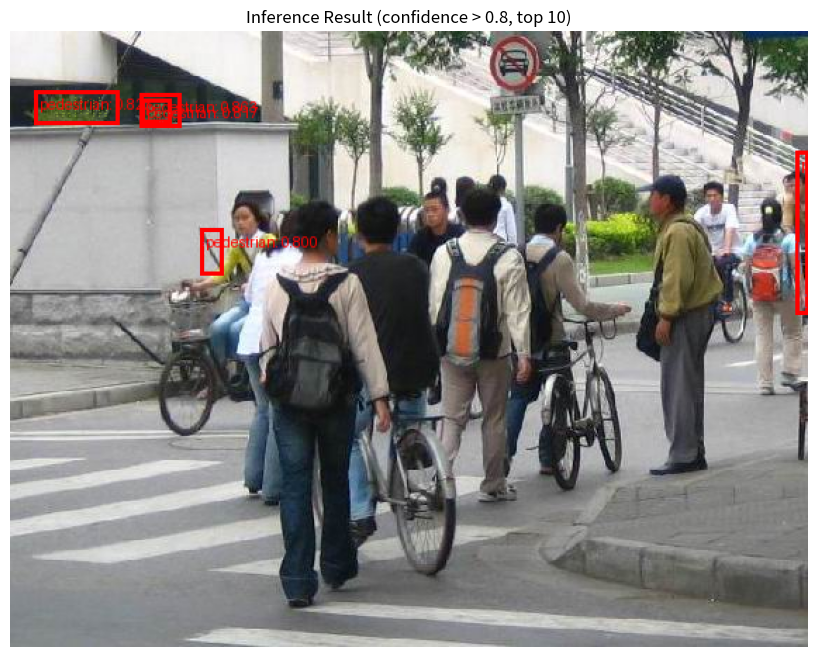


=== 予測統計 ===
全予測数: 100
信頼度 > 0.8: 5
最高信頼度: 0.863
平均信頼度: 0.739
信頼度 > 0.5: 100
信頼度 > 0.3: 100


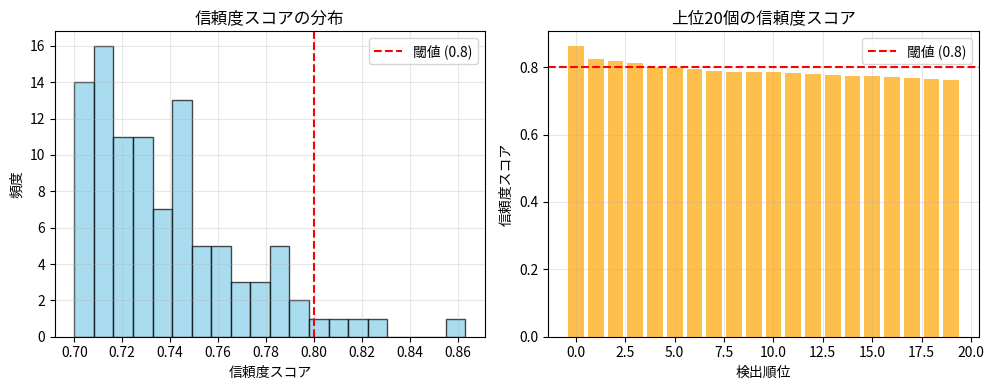

In [25]:
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision.io import read_image
from torchvision import transforms as T
from PIL import Image
import torch
import numpy as np
import japanese_font_config

def get_inference_transform():
    """
    推論専用のTransform（targetは不要）
    """
    return T.Compose([
        T.PILToTensor(),
        T.ConvertImageDtype(torch.float),
    ])

# 画像の読み込みと前処理
image_path = "/share/dtu_drone_tutorial/PennFudanPed/PNGImages/FudanPed00046.png"

# PILで読み込み（推論用transform用）
pil_image = Image.open(image_path).convert("RGB")
inference_transform = get_inference_transform()

model.eval()
with torch.no_grad():
    # 推論用のtransformを適用
    x = inference_transform(pil_image)
    x = x.to(device)
    predictions = model([x])
    pred = predictions[0]

# 可視化用の画像準備（元の形式）
original_image = read_image(image_path)
if original_image.shape[0] == 4:  # RGBA の場合
    original_image = original_image[:3, ...]  # RGB のみ取得

# 予測結果の処理（より厳しい信頼度フィルタリング）
confidence_threshold = 0.8  # ← 信頼度を上げる
high_conf_indices = pred["scores"] > confidence_threshold

# 上位N個の検出結果のみを表示（最大10個に制限）
if len(high_conf_indices.nonzero()) > 0:
    # スコアでソートして上位のみ選択
    sorted_indices = torch.argsort(pred["scores"], descending=True)
    top_indices = sorted_indices[:min(10, len(sorted_indices))]  # 最大10個
    
    # 信頼度フィルタリングとトップ制限を両方適用
    final_indices = []
    for idx in top_indices:
        if pred["scores"][idx] > confidence_threshold:
            final_indices.append(idx)
    
    if len(final_indices) > 0:
        final_indices = torch.tensor(final_indices)
        
        pred_labels = [f"pedestrian: {pred['scores'][idx]:.3f}" for idx in final_indices]
        pred_boxes = pred["boxes"][final_indices]
        
        # バウンディングボックスを描画
        output_image = draw_bounding_boxes(
            original_image, 
            pred_boxes.long(), 
            pred_labels, 
            colors="red",
            width=3
        )
        
        # マスクを描画（マスクが存在する場合）
        if "masks" in pred and len(pred["masks"][final_indices]) > 0:
            masks = (pred["masks"][final_indices] > 0.5).squeeze(1)
            
            # 色を動的に生成（マスクの数に応じて）
            num_masks = len(masks)
            colors = []
            for i in range(num_masks):
                # HSVカラースペースで色を生成
                hue = (i * 360 // num_masks) % 360
                colors.append(f"hsv({hue}, 70%, 80%)")
            
            output_image = draw_segmentation_masks(
                output_image, 
                masks, 
                alpha=0.4,  # 透明度を下げる
                colors=colors  # 動的に生成した色を使用
            )
        
        print(f"検出された物体数: {len(pred_labels)}")
        for i, (label, box) in enumerate(zip(pred_labels, pred_boxes)):
            print(f"  {i+1}: {label}, Box: [{box[0]:.1f}, {box[1]:.1f}, {box[2]:.1f}, {box[3]:.1f}]")
    else:
        output_image = original_image
        print("信頼度の高い検出結果がありませんでした。")
else:
    output_image = original_image
    print("信頼度の高い検出結果がありませんでした。")

# 可視化
plt.figure(figsize=(12, 8))
plt.imshow(output_image.permute(1, 2, 0))
plt.title(f'Inference Result (confidence > {confidence_threshold}, top 10)')
plt.axis('off')
plt.show()

# 全ての予測結果の統計
print(f"\n=== 予測統計 ===")
print(f"全予測数: {len(pred['scores'])}")
print(f"信頼度 > {confidence_threshold}: {len(pred['scores'][pred['scores'] > confidence_threshold])}")
if len(pred["scores"]) > 0:
    print(f"最高信頼度: {pred['scores'].max():.3f}")
    print(f"平均信頼度: {pred['scores'].mean():.3f}")
    print(f"信頼度 > 0.5: {len(pred['scores'][pred['scores'] > 0.5])}")
    print(f"信頼度 > 0.3: {len(pred['scores'][pred['scores'] > 0.3])}")

# 信頼度分布のヒストグラム表示
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.hist(pred['scores'].cpu().numpy(), bins=20, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('信頼度スコア')
plt.ylabel('頻度')
plt.title('信頼度スコアの分布')
plt.axvline(x=confidence_threshold, color='red', linestyle='--', label=f'閾値 ({confidence_threshold})')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
# 上位20個のスコアを表示
top_20_scores = pred['scores'].cpu().numpy()[:20]
plt.bar(range(len(top_20_scores)), top_20_scores, color='orange', alpha=0.7)
plt.xlabel('検出順位')
plt.ylabel('信頼度スコア')
plt.title('上位20個の信頼度スコア')
plt.axhline(y=confidence_threshold, color='red', linestyle='--', label=f'閾値 ({confidence_threshold})')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()